# Olfaction data analysis

This notebook demonstrates how to reproduce the essential elements of Fig. 3 in:

> [**Discovering precise temporal patterns in large-scale neural recordings through robust and interpretable time warping**](https://doi.org/10.1016/j.neuron.2019.10.020). Williams AH, Poole B, Maheswaranathan N, Dhawale AK, Fisher T, Wilson CD, Brann DH, Trautmann E, Ryu S, Shusterman R, Rinberg D, Ölveczky BP, Shenoy KV, Ganguli S (2020). *Neuron*. 105(2):246-259.e8

These data were collected by Chris Wilson in Dmitry Rinberg's lab, and are described in detail in the following paper, which should be cited if these data are re-used.

> [**A primacy code for odor identity**](https://www.nature.com/articles/s41467-017-01432-4). Wilson CD, Serrano GO, Koulakov AA, Rinberg D (2017). *Nature Communications*. 8:1477

Further questions regarding this data should be directed to rinberg@nyu.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load Data

In [2]:
# Raw data (data for pinene odor, 1e-2 M, from one animal).
Z = dict(np.load("pinene_data.npz"))

# Spiking data.
from affinewarp import SpikeData
data = SpikeData(
    Z["trials"],
    Z["spiketimes"],
    Z["neuron_ids"],
    tmin=Z["tmin"],
    tmax=Z["tmax"],
)

# Encode sniff onsets as a fraction between zero (stim onset) and one (trial end).
frac_onsets = Z["sniff_onsets"] / Z["tmax"]

#### Hyperparameters (can be fiddled with)

In [3]:
NBINS = 130         # Number of time bins per trial
SMOOTH_REG = 10.0   # Strength of roughness penalty
WARP_REG = 0.0      # Strength of penalty on warp magnitude
L2_REG = 0.0        # Strength of L2 penalty on template magnitude
MAXLAG = 0.5        # Maximum amount of shift allowed.

In [4]:
# Specify model.
from affinewarp import ShiftWarping
shift_model = ShiftWarping(
    maxlag=MAXLAG,
    smoothness_reg_scale=SMOOTH_REG,
    warp_reg_scale=WARP_REG,
    l2_reg_scale=L2_REG,
)

# Fit and apply warping to held out neurons.
from affinewarp.crossval import heldout_transform
validated_alignments = heldout_transform(
    shift_model, data.bin_spikes(NBINS), data, iterations=100)

# Fit model to full dataset (used to align sniffs).
shift_model.fit(data.bin_spikes(NBINS))

# NOTE: various preprocessing and normalizations schemes (z-scoring,
# square-root-transforming the spike counts, etc.) could be tried here.

Loss: 0.06: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


In [5]:
# Manually specify an alignment to sniff onsets.
from affinewarp import PiecewiseWarping
align_sniff = PiecewiseWarping()
align_sniff.manual_fit(
    data.bin_spikes(NBINS),
    np.column_stack([frac_onsets, np.full(data.n_trials, 0.4)]),
    recenter=False
)

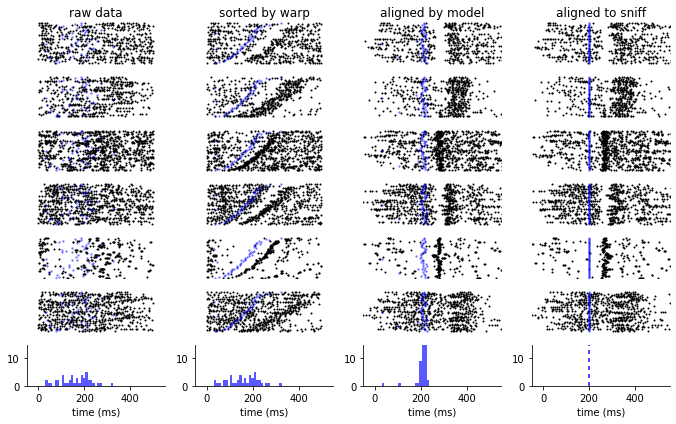

In [6]:
def _plot_column(axc, spks, sniffs):
    """
    Plots column of subplots.
    
    Parameters
    ----------
    axc : array, holding list of axes in column.
    spks : SpikeData object
    sniffs : array, holding sniff time on each trial.
    """
    
    # These are the neurons shown in the paper.
    example_neurons = [2, 6, 20, 22, 28, 9]

    # Plot raster plot for each neuron.
    raster_kws = dict(s=4, c='k', lw=0)
    for n, ax in zip(example_neurons, axc[:-1]):
        ax.scatter(
            spks.spiketimes[spks.neurons == n],
            spks.trials[spks.neurons == n],
            **raster_kws,
        )
        ax.set_ylim(-1, len(sniffs))
        ax.axis('off')

        # Plot blue dots, denoting sniffs, on rasters.
        sniff_kws = dict(c='b', s=5, alpha=.55, lw=0)
        ax.scatter(sniffs, range(sniffs.size), **sniff_kws)

    # Plot histogram at bottom.
    histbins = np.linspace(0, 500, 50)
    if len(np.unique(np.histogram(sniffs, histbins)[0])) == 2:
        axc[-1].axvline(sniffs.mean(), c='b', alpha=.7, lw=2, dashes=[2,2])
    else:
        axc[-1].hist(sniffs, histbins, color='blue', alpha=.65)
    
    # Format bottom subplot.
    axc[-1].spines['right'].set_visible(False)
    axc[-1].spines['top'].set_visible(False)
    axc[-1].set_ylim(0, 15)


# Create figure.
fig, axes = plt.subplots(7, 4, figsize=(9.5, 6))


# First column, raw data.
_plot_column(
    axes[:, 0], data, Z["sniff_onsets"]
)

# Second column, re-sorted trials by warping function.
_plot_column(
    axes[:, 1],
    data.reorder_trials(shift_model.argsort_warps()),
    Z["sniff_onsets"][shift_model.argsort_warps()]
)

# Third column, shifted alignment.
_plot_column(
    axes[:, 2],
    validated_alignments,
    shift_model.event_transform(
        range(Z["sniff_onsets"].size), frac_onsets) * Z["tmax"],
)

# Final column, aligned to sniff onset.
_plot_column(
    axes[:, 3],
    align_sniff.transform(data),
    align_sniff.event_transform(
        range(Z["sniff_onsets"].size), frac_onsets) * Z["tmax"],
)

# Final formatting.
for ax in axes.ravel():
    ax.set_xlim(-50, 550)
for ax in axes[-1]:
    ax.set_xlabel("time (ms)")

axes[0, 0].set_title("raw data")
axes[0, 1].set_title("sorted by warp")
axes[0, 2].set_title("aligned by model")
axes[0, 3].set_title("aligned to sniff")

fig.tight_layout()
fig.subplots_adjust(hspace=.3)